In [1]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable
import matplotlib.pyplot as plt
from cartopy import crs, feature

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/jvalenti/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/jvalenti/MOAD/grid/bathymetry_202108.nc',
'out': '/home/jvalenti/MOAD/results',
'home': '/home/jvalenti/MOAD/analysis-jose/notebooks/parcels',
'anim': '/home/jvalenti/MOAD/animations'}


In [4]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [5]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)


In [6]:
#Definitions
start = datetime(2022, 8, 23) #Start date
length = 2 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 150 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [7]:
#Set deploy coordinates following yaml   
clat = [48.24432386965075,48.400439430194574]
clon = [-124.14657923535806,-124.06757317406456]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [8]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)

In [9]:
#Set start date time and the name of the output file
name = 'Test only advection '
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_nomix = os.path.join(path['out'], fn)

In [10]:
####BUILD FIELDS FOR SIMULATION######
local = 0

varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)


#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)


dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht','time': 'time_counter'}
R = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(R)


#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)

#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0) 
    status = Variable('status', initial =  1) 

In [11]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset2 = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [19]:
def Advection(particle, fieldset, time): 
    if particle.status == 1:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t)
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt)
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/td
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

def turb_mix(particle,fieldset,time):
    if particle.status==1:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

        deg2met = 111319.5
        latT = 0.6495 
        kh = 1.5 #SSC constant value
        Rrx = ParcelsRandom.uniform(-1, 1)
        Rry = ParcelsRandom.uniform(-1, 1)
        d_x = (sqrt(3*2*kh*particle.dt) * Rrx)/(deg2met*latT)
        d_y = (sqrt(3*2*kh*particle.dt) * Rry)/deg2met   
        d_randomx = particle.lon + d_x + particle_dlon
        d_randomy = particle.lat + d_y + particle_dlat
        Sbh = 1
        Swh = 1
        if particle.depth < 5:
            Sbh = fieldset.sigma_theta[time, 0.51, d_randomy, d_randomx] #Check if particles reach coast at surface (SW Density = 0)
            if Sbh==0:
                print('particle beached')
                particle.status = 2 
        else:
            Swh = fieldset.sigma_theta[time, particle.depth, d_randomy, d_randomx]
            if Swh == 0:
                print('particle hit wall') #Do not cross wall Keep partilce in place
                particle.status = -1


    
def Displacement(particle,fieldset,time):
    '''Apply movement calculated by other kernels'''
    if particle.status==1:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        else:
            particle_ddepth += dzs #apply mixing  

        #Apply horizontal mixing (beaching for particles pushed through coast) 
        if particle.status == 1:
            particle_dlat += d_y
            particle_dlon += d_x
        elif particle.status == -1:
            particle.status = 1 #Do nothing, and resuspend

def export(particle,fieldset,time):
    if particle.status==1:
        test =  -particle.lat*0.84120957 -83.98027258 #Checking if particle gets too close to boundary JdF
        test2 = particle.lon*0.35157547 +90.26497859 #checking southern model boundary
        if particle.lon<test:
            particle.status = 5
        if particle.lat<test2:
            if particle.depth < 5:
                particle.status =2 #beached
                print('beached south')
            else:
                particle_dlat += 0.1*particle.dt/deg2met 
        
def CheckOutOfBounds2(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds: 
        particle.delete()

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        if Sbh == 0: #Ready to beach particles
            print('particle beached')
            particle.state = StatusCode.Success
            particle.status = 2 #beached DO NOT MOVE outside domain
        elif Swh ==0:
            print('particle hit wall') #Do not cross wall Keep partilce in place
            particle.state = StatusCode.Success
            #particle.status = -1 #crossed the wall
        else:
            print('lost Particle')
            particle.status = 10 #lost
            particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success


In [13]:
pset2.execute([Advection,CheckOutOfBounds,export,KeepInOcean],
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile_nomix, outputdt=timedelta(hours=odt)))

In [ ]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection20220823_1n_20220825_1n.zarr.
100%|██████████| 172800.0/172800.0 [02:07<00:00, 1356.40it/s]


In [ ]:
ds1 = xr.open_zarr(outfile)
advection = np.abs(ds1.wa)
mixing = np.abs(ds1.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
#pae = pa.std(dim='trajectory').values/np.sqrt(pa.shape[0]) Very small, not worth plotting
depth1 = ds1.z*ds1.fact

ds1_nomix = xr.open_zarr(outfile_nomix)
depth1_nomix = ds1_nomix.z*ds1_nomix.fact


/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Juan de Fuca August 2022')

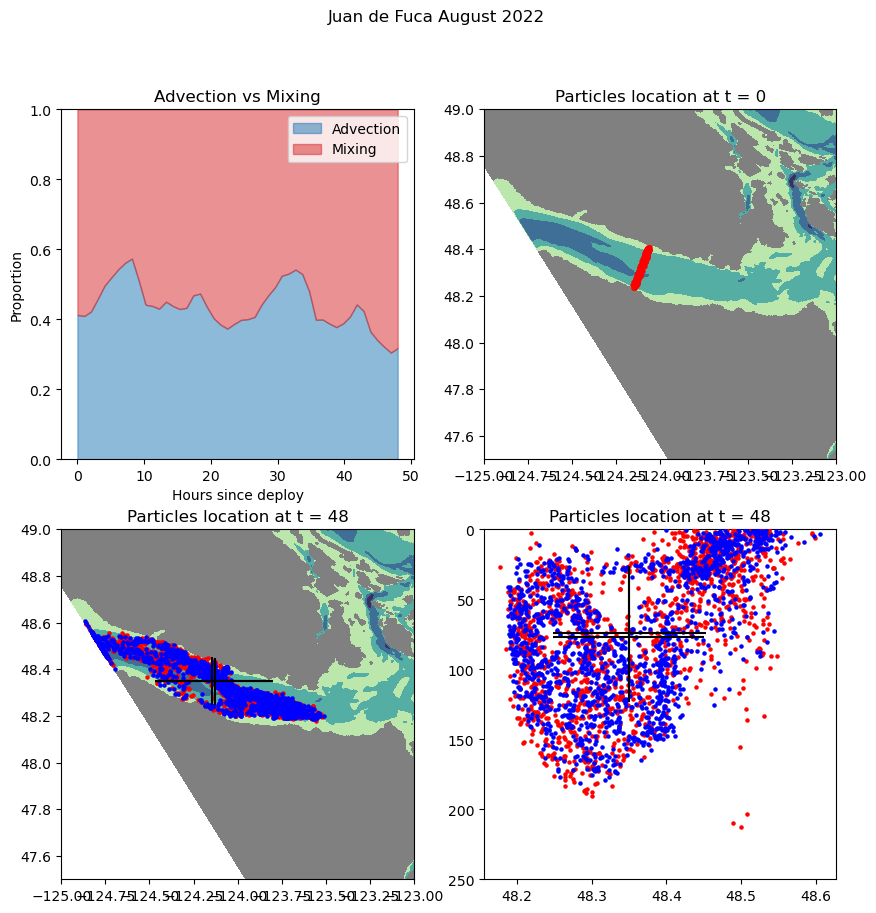

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47.5,49])
axs[0,1].set_xlim([-125,-123])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47.5,49])
axs[1,0].set_xlim([-125,-123])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds1.lon.mean(dim='trajectory')[-1], ds1.lat.mean(dim='trajectory')[-1], yerr= ds1.lat.std(dim='trajectory')[-1], xerr= ds1.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds1.lat.mean(dim='trajectory')[-1], depth1.mean(dim='trajectory')[-1], xerr= ds1.lat.std(dim='trajectory')[-1], yerr= depth1.std(dim='trajectory')[-1],zorder=5,c='k')
plt.suptitle('Juan de Fuca August 2022')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1_nomix.lon[:,-1],ds1_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_ylim([47.5,49])
axs[1,0].set_xlim([-125,-123])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds1_nomix.lon.mean(dim='trajectory')[-1], ds1_nomix.lat.mean(dim='trajectory')[-1], yerr= ds1_nomix.lat.std(dim='trajectory')[-1], xerr= ds1_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1_nomix.lat[:,-1],depth1_nomix[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds1_nomix.lat.mean(dim='trajectory')[-1], depth1_nomix.mean(dim='trajectory')[-1], xerr= ds1_nomix.lat.std(dim='trajectory')[-1], yerr= depth1_nomix.std(dim='trajectory')[-1],zorder=5,c='k')
plt.suptitle('Juan de Fuca August 2022')

In [ ]:
#Set deploy coordinates following yaml   
clat = [48.51840443015886,48.537040558621186]
clon = [-123.32656937706203,-123.17742577292043]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,50,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [ ]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection Haro'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile2 = os.path.join(path['out'], fn)

#Set start date time and the name of the output file
name = 'advection Haro'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile2_nomix = os.path.join(path['out'], fn)

In [ ]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset2 = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [ ]:
pset.execute([Advection,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile2_nomix, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/advection Haro20220823_1n_20220825_1n.zarr.
100%|██████████| 172800.0/172800.0 [01:45<00:00, 1643.35it/s]


In [ ]:
pset2.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile2, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection Haro20220823_1n_20220825_1n.zarr.
100%|██████████| 172800.0/172800.0 [02:06<00:00, 1364.20it/s]


In [ ]:
ds2 = xr.open_zarr(outfile2)
advection = np.abs(ds2.wa)
mixing = np.abs(ds2.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values

depth2 = ds2.z*ds2.fact

ds2_nomix = xr.open_zarr(outfile2_nomix)
depth2_nomix = ds2_nomix.z*ds2_nomix.fact

/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Haro Strait August 2022')

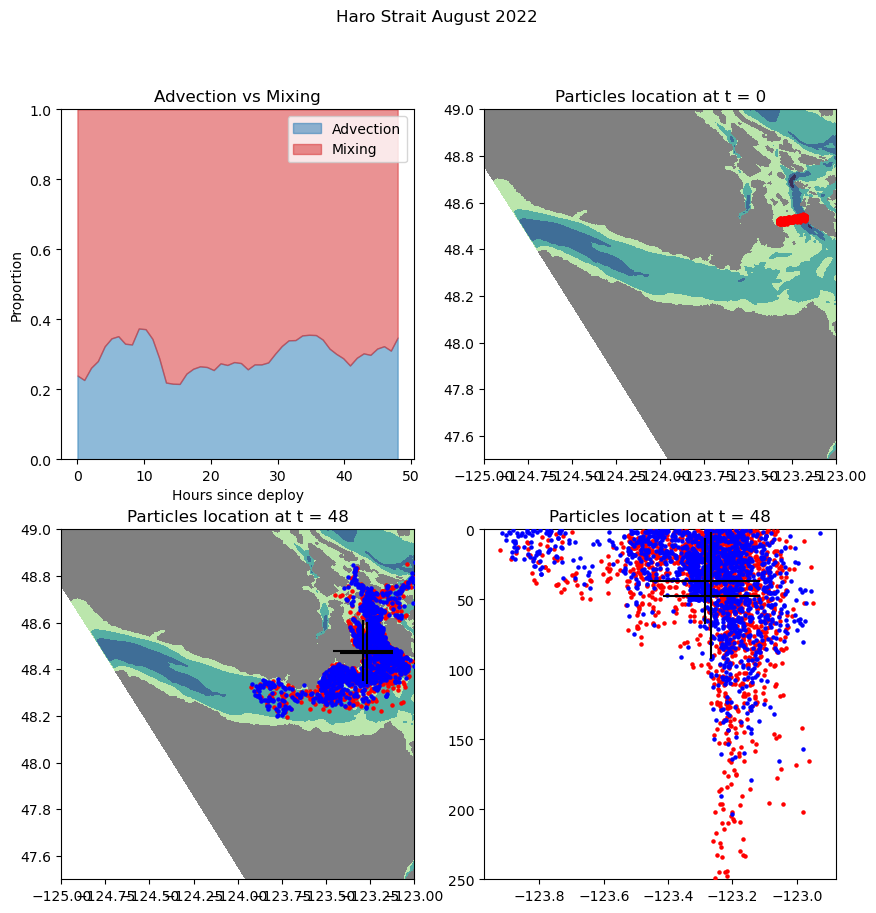

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds2.lon[:,0],ds2.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47.5,49])
axs[0,1].set_xlim([-125,-123])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds2.lon[:,-1],ds2.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47.5,49])
axs[1,0].set_xlim([-125,-123])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds2.lon.mean(dim='trajectory')[-1], ds2.lat.mean(dim='trajectory')[-1], yerr= ds2.lat.std(dim='trajectory')[-1], xerr= ds2.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds2.lon[:,-1],depth2[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds2.lon.mean(dim='trajectory')[-1], depth2.mean(dim='trajectory')[-1], xerr= ds2.lon.std(dim='trajectory')[-1], yerr= depth2.std(dim='trajectory')[-1],zorder=5,c='k')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds2_nomix.lon[:,-1],ds2_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_ylim([47.5,49])
axs[1,0].set_xlim([-125,-123])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds2_nomix.lon.mean(dim='trajectory')[-1], ds2_nomix.lat.mean(dim='trajectory')[-1], yerr= ds2_nomix.lat.std(dim='trajectory')[-1], xerr= ds2_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds2_nomix.lon[:,-1],depth2_nomix[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds2_nomix.lon.mean(dim='trajectory')[-1], depth2_nomix.mean(dim='trajectory')[-1], xerr= ds2_nomix.lon.std(dim='trajectory')[-1], yerr= depth2_nomix.std(dim='trajectory')[-1],zorder=5,c='k')

plt.suptitle('Haro Strait August 2022')

In [ ]:
#Definitions
start = datetime(2022, 8, 1) #Start date
length = 2 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 200 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [ ]:
#Set deploy coordinates following yaml   
clat = [49.27407925138779,49.455498254953405]
clon = [-124.03583927975743,-123.84282669916357]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [ ]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection SoG'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile3 = os.path.join(path['out'], fn)

name = 'advection SoG'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile3_nomix = os.path.join(path['out'], fn)

In [ ]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset2 = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [ ]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile3, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection SoG20220801_1n_20220803_1n.zarr.
100%|██████████| 172800.0/172800.0 [00:14<00:00, 11642.76it/s]


In [ ]:
pset2.execute([Advection,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile3_nomix, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/advection SoG20220801_1n_20220803_1n.zarr.
100%|██████████| 172800.0/172800.0 [00:13<00:00, 13114.03it/s]


In [ ]:
ds3 = xr.open_zarr(outfile3)
advection = np.abs(ds3.wa)
mixing = np.abs(ds3.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
depth3 = ds3.z*ds3.fact

ds3_nomix = xr.open_zarr(outfile3_nomix)
depth3_nomix = ds3_nomix.z*ds3_nomix.fact

/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'SoG August 2022')

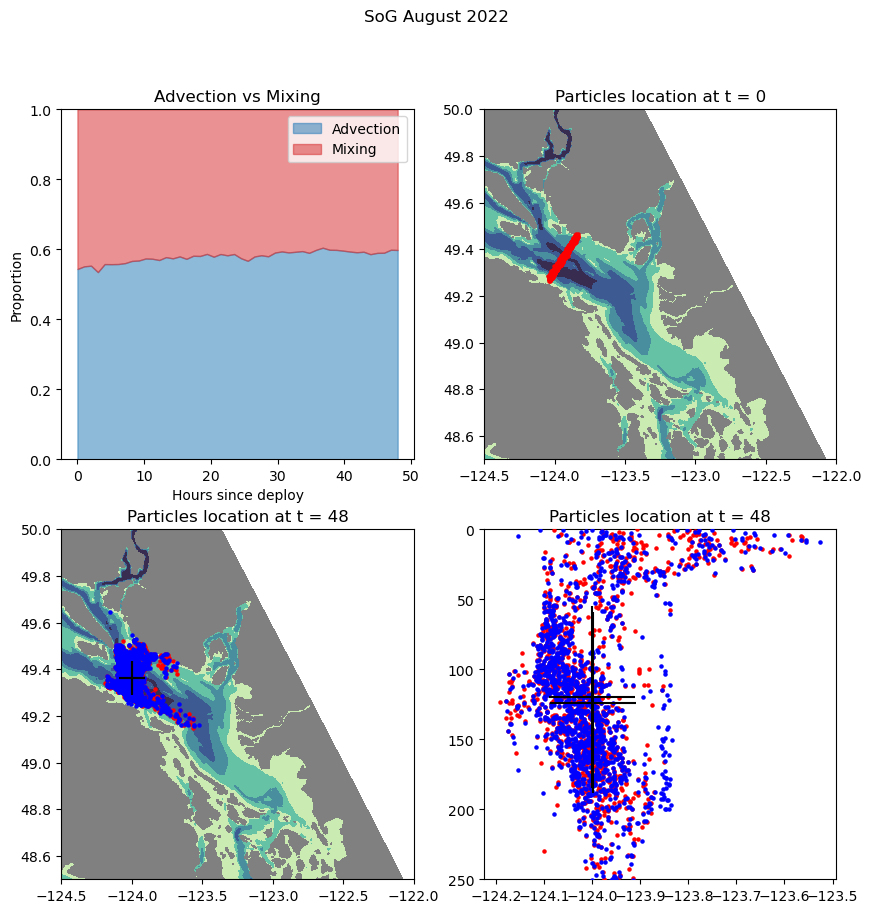

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,550,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds3.lon[:,0],ds3.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([48.5,50])
axs[0,1].set_xlim([-124.5,-122])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3.lon[:,-1],ds3.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([48.5,50])
axs[1,0].set_xlim([-124.5,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3.lon.mean(dim='trajectory')[-1], ds3.lat.mean(dim='trajectory')[-1], yerr= ds3.lat.std(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3.lon[:,-1],depth3[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
axs[1,1].errorbar(ds3.lon.mean(dim='trajectory')[-1], depth3.mean(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1], yerr= depth3.std(dim='trajectory')[-1],zorder=5,c='k')
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3_nomix.lon[:,-1],ds3_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], ds3_nomix.lat.mean(dim='trajectory')[-1], yerr= ds3_nomix.lat.std(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3_nomix.lon[:,-1],depth3_nomix[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], depth3_nomix.mean(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1], yerr= depth3_nomix.std(dim='trajectory')[-1],zorder=5,c='k')


plt.suptitle('SoG August 2022')

In [13]:
#Set deploy coordinates following yaml   
clat=[47.13828390533667]
clon= [-122.74328198321214]
N=1
n =1000
dd = 50
duration = timedelta(days=1)
#Set deploy locations

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [14]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection puget'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile3 = os.path.join(path['out'], fn)

name = 'advection puget'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile3_nomix = os.path.join(path['out'], fn)

In [15]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset2 = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [16]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile3, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection puget20220823_1n_20220824_1n.zarr.
  0%|          | 0/86400.0 [00:00<?, ?it/s]particle hit wall
particle hit wall
  0%|          | 90.0/86400.0 [00:03<52:17, 27.50it/s]particle beached
  2%|▏         | 1800.0/86400.0 [00:03<02:18, 612.93it/s]particle beached
particle beached
  4%|▍         | 3600.0/86400.0 [00:06<02:05, 660.50it/s]beached south
  6%|▋         | 5400.0/86400.0 [00:07<01:19, 1020.91it/s]beached south
particle beached
  8%|▊         | 7200.0/86400.0 [00:09<01:32, 860.41it/s] beached south
beached south
 10%|█         | 9000.0/86400.0 [00:10<01:07, 1154.07it/s]beached south
particle beached
 12%|█▎        | 10800.0/86400.0 [00:12<01:20, 938.21it/s]beached south
particle beached
beached south
particle beached
particle beached
beached south
beached south
beached south
beached south
particle beached
beached south
beached south
 15%|█▍        | 12600.0/86400.0 [00:13<01:01, 1204.37it/s]beache

In [20]:
pset2.execute([Advection,CheckOutOfBounds2,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile3_nomix, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/advection puget20220823_1n_20220824_1n.zarr.
100%|██████████| 86400.0/86400.0 [00:56<00:00, 1541.68it/s]


In [24]:
ds3 = xr.open_zarr(outfile3)
advection = np.abs(ds3.wa)
mixing = np.abs(ds3.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,1*24,int(1*24/odt))
pam = pa.mean(dim='trajectory').values
depth3 = ds3.z*ds3.fact

ds3_nomix = xr.open_zarr(outfile3_nomix)
depth3_nomix = ds3_nomix.z*ds3_nomix.fact

Text(0.5, 0.98, 'SoG August 2022')

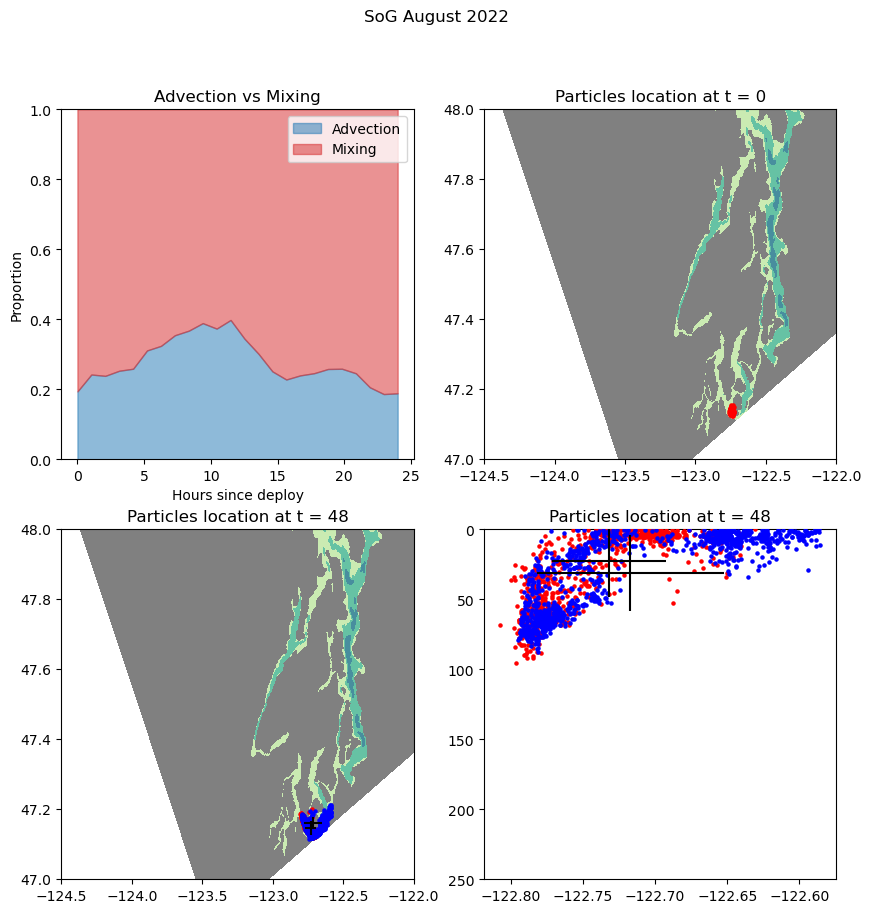

In [25]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,550,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds3.lon[:,0],ds3.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47,48])
axs[0,1].set_xlim([-124.5,-122])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3.lon[:,-1],ds3.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47,48])
axs[1,0].set_xlim([-124.5,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3.lon.mean(dim='trajectory')[-1], ds3.lat.mean(dim='trajectory')[-1], yerr= ds3.lat.std(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3.lon[:,-1],depth3[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
axs[1,1].errorbar(ds3.lon.mean(dim='trajectory')[-1], depth3.mean(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1], yerr= depth3.std(dim='trajectory')[-1],zorder=5,c='k')
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3_nomix.lon[:,-1],ds3_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], ds3_nomix.lat.mean(dim='trajectory')[-1], yerr= ds3_nomix.lat.std(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3_nomix.lon[:,-1],depth3_nomix[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], depth3_nomix.mean(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1], yerr= depth3_nomix.std(dim='trajectory')[-1],zorder=5,c='k')


plt.suptitle('SoG August 2022')

In [26]:
import scipy.stats as scps

print(scps.ttest_ind(depth1[:,-1], depth1_nomix[:,-1]))
print(scps.ttest_ind(depth2[:,-1], depth2_nomix[:,-1]))
print(scps.ttest_ind(depth3[:,-1], depth3_nomix[:,-1]))

NameError: name 'depth1' is not defined

In [ ]:
statt = []
pval = []
for t in range(depth1.shape[1]):
    a,b = scps.ttest_ind(depth1[:,t],depth1_nomix[:,t])
    statt.append(a)
    pval.append(b)
statt2 = []
pval2 = []
for t in range(depth1.shape[1]):
    a,b = scps.ttest_ind(depth2[:,t],depth2_nomix[:,t])
    statt2.append(a)
    pval2.append(b)
statt3 = []
pval3 = []
for t in range(depth1.shape[1]):
    a,b = scps.ttest_ind(depth3[:,t],depth3_nomix[:,t])
    statt3.append(a)
    pval3.append(b)

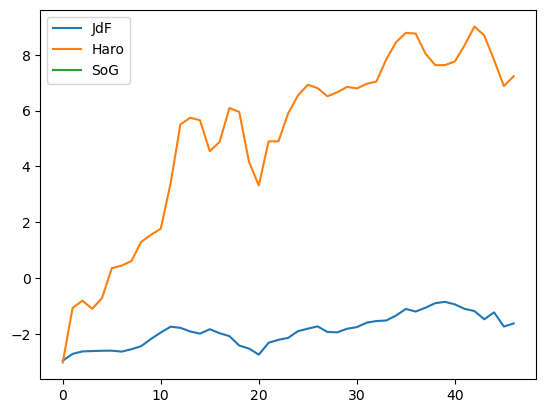

In [ ]:
plt.plot(statt[1:],label='JdF')
plt.plot(statt2[1:],label='Haro')
plt.plot(statt3[1:],label='SoG')
plt.legend()